In [1]:
import sagemaker
from pathlib import Path
from sagemaker.predictor import json_serializer 
import json

In [2]:
import os 
import boto3 
import re 
from sagemaker import get_execution_role
role = get_execution_role()

In [3]:
import gc 
import os
import fileinput 
import string
import zipfile 
import datetime 
import sys
import nltk

In [4]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,roc_auc_score

In [5]:
import pandas as pd 
import numpy as np 
bucket = 'chau-testbucket'
prefix = 'sagemaker/BERT-analyse-sentiment'


In [36]:
# Importer les données 
df = pd.read_csv('https://chau-testbucket.s3-eu-west-1.amazonaws.com/Tweets.csv')

In [37]:
df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [38]:
df = df[['airline_sentiment','text',]]

In [39]:
df.rename(columns={'airline_sentiment':'label'},inplace=True)

In [40]:
df.head()

label                                               text
0   neutral                @VirginAmerica What @dhepburn said.
1  positive  @VirginAmerica plus you've added commercials t...
2   neutral  @VirginAmerica I didn't today... Must mean I n...
3  negative  @VirginAmerica it's really aggressive to blast...
4  negative  @VirginAmerica and it's a really big bad thing...

In [41]:
df.count()

label    14640
text     14640
dtype: int64

In [42]:
df.loc[:,'label'] = df.label.map(({'negative':0,'neutral':2,'positive':1}))

In [43]:
df.head()

label                                               text
0      2                @VirginAmerica What @dhepburn said.
1      1  @VirginAmerica plus you've added commercials t...
2      2  @VirginAmerica I didn't today... Must mean I n...
3      0  @VirginAmerica it's really aggressive to blast...
4      0  @VirginAmerica and it's a really big bad thing...

In [44]:
# Netoyyer le text #
def preprocess_tweet(tweet):
    #Preprocess the text in a single tweet
    #arguments: tweet = a single tweet in form of string 
    #convert the tweet to lower case
    tweet.lower()
    #convert all urls to sting "URL"
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #convert all @username to "at_user"
    #tweet = re.sub('@[^\s]+','AT_USER', tweet)
    #correct all multiple white spaces to a single white space
    tweet = re.sub('[\s]+', ' ', tweet)
    #convert "#topic" to just "topic"
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    return tweet

In [45]:
df['text'] = df['text'].apply(preprocess_tweet)

In [46]:
df.head()

label                                               text
0      2                @VirginAmerica What @dhepburn said.
1      1  @VirginAmerica plus you've added commercials t...
2      2  @VirginAmerica I didn't today... Must mean I n...
3      0  @VirginAmerica it's really aggressive to blast...
4      0  @VirginAmerica and it's a really big bad thing...

In [47]:
# Matirce de test # 
sentences = df.text.values

In [48]:
sentences

array(['@VirginAmerica What @dhepburn said.',
       "@VirginAmerica plus you've added commercials to the experience... tacky.",
       "@VirginAmerica I didn't today... Must mean I need to take another trip!",
       ..., '@AmericanAir Please bring American Airlines to BlackBerry10',
       "@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",
       '@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?'],
      dtype=object)

In [49]:
# On doit ajouter les spéciales token au débutet à la fin de chaque phare pourque BERT puisse travailler propely # 
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
# CLS : (Stands for classification), SEP : (Separate end part)

In [50]:
sentences[1]

"[CLS] @VirginAmerica plus you've added commercials to the experience... tacky. [SEP]"

In [22]:
!pip install --upgrade pip

    100% |████████████████████████████████| 1.4MB 21.9MB/s ta 0:00:01
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1


In [23]:
# Importer le libary fast-bert pour déployer sur Amazon SageMaker #
!pip install git+https://github.com/kaushaltrivedi/fast-bert.git

  Cloning https://github.com/kaushaltrivedi/fast-bert.git to /tmp/pip-req-build-zsidg7lk
  Running command git clone -q https://github.com/kaushaltrivedi/fast-bert.git /tmp/pip-req-build-zsidg7lk
     |████████████████████████████████| 204kB 29.6MB/s eta 0:00:01
     |████████████████████████████████| 10.4MB 37.4MB/s eta 0:00:01
     |████████████████████████████████| 450kB 47.6MB/s eta 0:00:01
     |████████████████████████████████| 61kB 12.7MB/s eta 0:00:01
     |█████████████████▊              | 406.1MB 65.0MB/s eta 0:00:06    |████▍                           | 99.5MB 57.2MB/s eta 0:00:12     |███████▋                        | 174.7MB 57.5MB/s eta 0:00:10

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |██████████████████▉             | 432.4MB 65.0MB/s eta 0:00:05

     |███████████████████             | 435.7MB 65.0MB/s eta 0:00:05

     |███████████████████▏            | 438.9MB 65.0MB/s eta 0:00:05

     |███████████████████▎            | 442.2MB 65.0MB/s eta 0:00:05

     |███████████████████▍            | 445.5MB 65.0MB/s eta 0:00:05

     |███████████████████▌            | 448.8MB 65.0MB/s eta 0:00:05

     |███████████████████▊            | 452.1MB 65.0MB/s eta 0:00:05

     |███████████████████▉            | 455.4MB 65.0MB/s eta 0:00:05

     |████████████████████            | 458.7MB 65.0MB/s eta 0:00:05

     |████████████████████▏           | 462.0MB 65.0MB/s eta 0:00:05

     |████████████████████▎           | 465.2MB 65.0MB/s eta 0:00:05

     |████████████████████▍           | 468.5MB 65.0MB/s eta 0:00:05

     |████████████████████▌           | 471.8MB 63.8MB/s eta 0:00:05

     |████████████████████▊           | 475.1MB 63.8MB/s eta 0:00:05

     |████████████████████▉           | 478.4MB 63.8MB/s eta 0:00:05

     |█████████████████████           | 481.6MB 63.8MB/s eta 0:00:04

     |█████████████████████▏          | 484.9MB 63.8MB/s eta 0:00:04

     |█████████████████████▎          | 488.2MB 63.8MB/s eta 0:00:04

     |█████████████████████▍          | 491.5MB 63.8MB/s eta 0:00:04

     |█████████████████████▌          | 494.7MB 63.8MB/s eta 0:00:04

     |█████████████████████▊          | 498.0MB 63.8MB/s eta 0:00:04

     |█████████████████████▉          | 501.3MB 63.8MB/s eta 0:00:04

     |██████████████████████          | 504.6MB 63.8MB/s eta 0:00:04

     |██████████████████████▏         | 507.8MB 63.8MB/s eta 0:00:04

     |██████████████████████▎         | 511.1MB 63.8MB/s eta 0:00:04

     |██████████████████████▍         | 514.4MB 63.8MB/s eta 0:00:04

     |██████████████████████▌         | 517.7MB 63.8MB/s eta 0:00:04

     |██████████████████████▊         | 521.0MB 63.8MB/s eta 0:00:04

     |██████████████████████▉         | 524.3MB 63.8MB/s eta 0:00:04

     |███████████████████████         | 527.5MB 63.8MB/s eta 0:00:04

     |███████████████████████▏        | 530.8MB 63.8MB/s eta 0:00:04

     |███████████████████████▎        | 534.1MB 63.8MB/s eta 0:00:04

     |███████████████████████▍        | 537.4MB 63.8MB/s eta 0:00:04

     |███████████████████████▌        | 540.7MB 63.8MB/s eta 0:00:04

     |███████████████████████▊        | 543.9MB 63.8MB/s eta 0:00:03

     |███████████████████████▉        | 547.2MB 63.8MB/s eta 0:00:03

     |████████████████████████        | 550.5MB 63.8MB/s eta 0:00:03

     |████████████████████████▏       | 553.8MB 63.8MB/s eta 0:00:03

     |████████████████████████▎       | 557.1MB 63.8MB/s eta 0:00:03

     |████████████████████████▍       | 560.4MB 63.8MB/s eta 0:00:03

     |████████████████████████▌       | 563.7MB 63.8MB/s eta 0:00:03

     |████████████████████████▊       | 567.0MB 63.8MB/s eta 0:00:03

     |████████████████████████▉       | 570.3MB 63.8MB/s eta 0:00:03

     |█████████████████████████       | 573.6MB 63.8MB/s eta 0:00:03

     |█████████████████████████▏      | 576.9MB 63.8MB/s eta 0:00:03

     |█████████████████████████▎      | 580.2MB 63.8MB/s eta 0:00:03

     |█████████████████████████▍      | 583.5MB 63.8MB/s eta 0:00:03

     |█████████████████████████▋      | 586.8MB 63.8MB/s eta 0:00:03

     |█████████████████████████▊      | 590.0MB 63.8MB/s eta 0:00:03

     |█████████████████████████▉      | 593.3MB 63.8MB/s eta 0:00:03

     |██████████████████████████      | 596.6MB 63.8MB/s eta 0:00:03

     |██████████████████████████▏     | 599.9MB 62.7MB/s eta 0:00:03

     |██████████████████████████▎     | 603.2MB 62.7MB/s eta 0:00:03

     |██████████████████████████▍     | 606.5MB 62.7MB/s eta 0:00:03

     |██████████████████████████▋     | 609.8MB 62.7MB/s eta 0:00:02

     |██████████████████████████▊     | 613.0MB 62.7MB/s eta 0:00:02

     |██████████████████████████▉     | 616.4MB 62.7MB/s eta 0:00:02

     |███████████████████████████     | 619.6MB 62.7MB/s eta 0:00:02

     |███████████████████████████▏    | 623.0MB 62.7MB/s eta 0:00:02

     |███████████████████████████▎    | 626.2MB 62.7MB/s eta 0:00:02

     |███████████████████████████▍    | 629.5MB 62.7MB/s eta 0:00:02

     |███████████████████████████▋    | 632.8MB 62.7MB/s eta 0:00:02

     |███████████████████████████▊    | 636.1MB 62.7MB/s eta 0:00:02

     |███████████████████████████▉    | 639.4MB 62.7MB/s eta 0:00:02

     |████████████████████████████    | 642.7MB 62.7MB/s eta 0:00:02

     |████████████████████████████▏   | 646.0MB 62.7MB/s eta 0:00:02

     |████████████████████████████▎   | 649.3MB 62.7MB/s eta 0:00:02

     |████████████████████████████▍   | 652.6MB 62.7MB/s eta 0:00:02

     |████████████████████████████▋   | 655.9MB 62.7MB/s eta 0:00:02

     |████████████████████████████▊   | 659.1MB 62.7MB/s eta 0:00:02

     |████████████████████████████▉   | 662.2MB 62.7MB/s eta 0:00:02

     |█████████████████████████████   | 665.4MB 63.3MB/s eta 0:00:02

     |█████████████████████████████▏  | 668.7MB 63.3MB/s eta 0:00:02

     |█████████████████████████████▎  | 672.0MB 63.3MB/s eta 0:00:01

     |█████████████████████████████▍  | 675.3MB 63.3MB/s eta 0:00:01

     |█████████████████████████████▋  | 678.6MB 63.3MB/s eta 0:00:01

     |█████████████████████████████▊  | 681.9MB 63.3MB/s eta 0:00:01

     |█████████████████████████████▉  | 685.2MB 63.3MB/s eta 0:00:01

     |██████████████████████████████  | 688.5MB 63.3MB/s eta 0:00:01

     |██████████████████████████████▏ | 691.8MB 63.3MB/s eta 0:00:01

     |██████████████████████████████▎ | 695.1MB 63.3MB/s eta 0:00:01

     |██████████████████████████████▍ | 698.4MB 63.3MB/s eta 0:00:01

     |██████████████████████████████▋ | 701.7MB 63.3MB/s eta 0:00:01

     |██████████████████████████████▊ | 705.0MB 63.3MB/s eta 0:00:01

     |██████████████████████████████▉ | 708.3MB 63.3MB/s eta 0:00:01

     |███████████████████████████████ | 711.5MB 63.3MB/s eta 0:00:01

     |███████████████████████████████▏| 714.8MB 63.3MB/s eta 0:00:01

     |███████████████████████████████▎| 718.1MB 63.3MB/s eta 0:00:01

     |███████████████████████████████▍| 721.4MB 63.3MB/s eta 0:00:01

     |███████████████████████████████▋| 724.7MB 63.3MB/s eta 0:00:01

     |███████████████████████████████▊| 728.0MB 63.1MB/s eta 0:00:01

     |███████████████████████████████▉| 731.3MB 63.1MB/s eta 0:00:01

     |████████████████████████████████| 734.6MB 63.1MB/s eta 0:00:01

     |████████████████████████████████| 734.6MB 17kB/s 
     |████████████████████████████████| 10.2MB 43.4MB/s eta 0:00:01
     |████████████████████████████████| 1.3MB 51.7MB/s eta 0:00:01
     |████████████████████████████████| 122kB 58.4MB/s eta 0:00:01
     |████████████████████████████████| 3.7MB 40.4MB/s eta 0:00:01
     |████████████████████████████████| 2.2MB 38.2MB/s eta 0:00:01
     |████████████████████████████████| 194kB 59.1MB/s eta 0:00:01
     |████████████████████████████████| 696kB 46.1MB/s eta 0:00:01███████                     | 235kB 46.1MB/s eta 0:00:01
     |████████████████████████████████| 1.0MB 38.2MB/s eta 0:00:01
     |████████████████████████████████| 860kB 42.9MB/s eta 0:00:01
     |████████████████████████████████| 133kB 55.4MB/s eta 0:00:01
     |████████████████████████████████| 296kB 57.5MB/s eta 0:00:01
     |████████████████████████████████| 552kB 48.3MB/s eta 0:00:01


  Created wheel for fast-bert: filename=fast_bert-1.6.0-cp36-none-any.whl size=74353 sha256=38323fd985d9f59963b87cab44f8a7c1c746777c3b52ea6f74900d3c04eafd02
  Stored in directory: /tmp/pip-ephem-wheel-cache-3yt2lrww/wheels/53/11/ef/67d507c8f4f05b843a6dd2c4f6360acdee4c79679c4ca36bc6
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1321 sha256=cb8a7ab593b57e728aee4f4675a890b6329ea16284649170ad7587b532f5a6f3
  Stored in directory: /home/ec2-user/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=884006 sha256=2fec4ac9c9a04608b474e5b27d0aa94c8f23d870e56cf11ff426d70981cd56d7
  Stored in directory: /home/ec2-user/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built fast-bert sklearn sacremoses
ERROR: blis 0.4.1 has requirement numpy>=1.15.0, but you'll have numpy 1.14.3 which is incompatible.
ERROR: spacy 2.2.3 has

In [26]:
# Importer tensorflow-cpu et gpu # 
!pip install tensorflow==1.13.1
!pip install tensorflow-gpu==1.13.1
!pip install keras==2.1.2

     |████████████████████████████████| 92.5MB 130kB/s  eta 0:00:01
     |████████████████████████████████| 112kB 55.7MB/s eta 0:00:01
     |████████████████████████████████| 51kB 12.5MB/s eta 0:00:01
     |████████████████████████████████| 2.4MB 41.0MB/s eta 0:00:01
     |████████████████████████████████| 3.2MB 54.7MB/s eta 0:00:01
     |████████████████████████████████| 368kB 52.7MB/s eta 0:00:01
     |████████████████████████████████| 51kB 12.4MB/s eta 0:00:01
     |████████████████████████████████| 92kB 4.6MB/s  eta 0:00:01
  Created wheel for absl-py: filename=absl_py-0.9.0-cp36-none-any.whl size=117800 sha256=1e59bb9ce00a2e9f483884c4578edd14dff683414d91c399c41c762f2278a97f
  Stored in directory: /home/ec2-user/.cache/pip/wheels/8e/28/49/fad4e7f0b9a1227708cbbee4487ac8558a7334849cb81c813d
  Created wheel for gast: filename=gast-0.3.2-cp36-none-any.whl size=8730 sha256=a7d6a0e67d9c001f1e61b9616187b28f49851748d6da417fa2687f33174e5388
  Stored in directory: /home/ec2-user/.cache/pip/w

     |████████████████████████████████| 307kB 10.2MB/s eta 0:00:01


In [24]:
# Importer pytorch-pretrained-bert# 
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 24.8MB/s eta 0:00:01


In [27]:
import tensorflow as tf

In [51]:
tf.test.is_built_with_cuda()

True

In [29]:
# GPU avaible sur Tensorflow # 
tf.test.is_gpu_available()

True

In [30]:
import torch

In [31]:
from pytorch_pretrained_bert.tokenization import BertTokenizer

In [52]:
sentences[0]

'[CLS] @VirginAmerica What @dhepburn said. [SEP]'

In [53]:
# Importer le dictionaire de token (WordPiece tokenization) de BERT, stock en variable tokenizer #
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Convertir les phares en token
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])
# Dans BERT, un mot peut couper en plusieurs petits-mots #

Tokenize the first sentence:
['[CLS]', '@', 'virgin', '##ame', '##rica', 'what', '@', 'dh', '##ep', '##burn', 'said', '.', '[SEP]']


In [54]:
print (tokenized_texts[1])

['[CLS]', '@', 'virgin', '##ame', '##rica', 'plus', 'you', "'", 've', 'added', 'commercials', 'to', 'the', 'experience', '.', '.', '.', 'tack', '##y', '.', '[SEP]']


In [55]:
print (tokenized_texts[2])

['[CLS]', '@', 'virgin', '##ame', '##rica', 'i', 'didn', "'", 't', 'today', '.', '.', '.', 'must', 'mean', 'i', 'need', 'to', 'take', 'another', 'trip', '!', '[SEP]']


In [56]:
# Loading the label value " 
labels = df.label.values

In [57]:
type(labels)
type(labels[0])

numpy.int64

In [58]:
# Chercher de length max des tweets dans le dataset # 
print(df.text.map(lambda x: len(x)).max())

186


In [59]:
# BERT demande de l'entrée des phares ont la meme 
# Set the maximum sequence length = 256 

MAX_LEN = 256

In [60]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

Using TensorFlow backend.


In [61]:
#  Utilisez le tokenizer BERT pour convertir les tokens en leurs numéros d'index dans le vocabulaire BERT
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [62]:
# Remplit chaque séquence à la même longueur (longueur de la séquence la plus longue #
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [76]:
# Imprimer pour voir 
input_ids[1]

array([  101,  1030,  6261, 14074, 14735,  4606,  2017,  1005,  2310,
        2794, 12698,  2000,  1996,  3325,  1012,  1012,  1012, 26997,
        2100,  1012,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [77]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
# 70% de dataset contient de l'échantillon d'apprentissage # 
# 30% de dataset contient de l'échantillon de test # 
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.3)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.3)

In [80]:
train_inputs[1]

array([ 101, 1030, 2142, 2151, 3382, 2017, 2071, 2393, 2128, 8654, 1029,
       1029, 2026, 3462, 8014, 3462, 3709,  102,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [82]:
train_masks[1]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [83]:
train_labels[1]

0

In [84]:
type(train_inputs)

numpy.ndarray

In [85]:
# Convert all of our data into tensors type de pytorch,the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [70]:
type(train_inputs)

torch.Tensor

In [88]:
train_inputs[2]

tensor([  101,  1030,  4943, 11215,  1052,  2860,  2213,  3622,  2000, 10108,
         2006, 18860,  1010,  2339,  2003,  2023,  2069,  6230,  1999,  2233,
         1029,  1045,  2245,  2009,  2001,  2183,  2000,  2022,  1037,  4568,
         2518,  1012,  1024,  1006,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [89]:
train_masks[2]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [48]:
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

In [49]:
# Select a batch size for training. For fine-tuning BERT on a specific task
# A batch size of 16 or 32 is preferred 
# If Cuda goes out of memory try lowering the batch_size.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [50]:
# Entrainement le modèle #
from pytorch_pretrained_bert import BertAdam,BertForSequenceClassification,BertTokenizer,BertConfig

In [51]:
# Load BertForSequenceClassification,  
# Choissir the num_label = 3 positive,negative,neutral
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

In [52]:
device = torch.device('cuda')

In [53]:
# check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    multi_gpu = True
else:
    multi_gpu = False

In [54]:
# Multi-GPU avaible #, donc on peut lancer le modèle # 
multi_gpu

True

In [55]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

In [57]:
n_gpu # 4 GPU # 

4

In [58]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [59]:
# Set different weight decays for different layers of the model.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [60]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=3e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [61]:
optimizer

BertAdam (
Parameter Group 0
    b1: 0.9
    b2: 0.999
    e: 1e-06
    lr: 3e-05
    max_grad_norm: 1.0
    schedule: <pytorch_pretrained_bert.optimization.WarmupLinearSchedule object at 0x7fd3d81ed860>
    weight_decay: 0.01
    weight_decay_rate: 0.01

Parameter Group 1
    b1: 0.9
    b2: 0.999
    e: 1e-06
    lr: 3e-05
    max_grad_norm: 1.0
    schedule: <pytorch_pretrained_bert.optimization.WarmupLinearSchedule object at 0x7fd3d81ed860>
    weight_decay: 0.01
    weight_decay_rate: 0.0
)

In [62]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [63]:
from tqdm import tqdm, trange

In [64]:
# Créer le vecteur loss
train_loss_set = []
# Nombre d'épochs (les auteurs recommandent de 2 à 4)
epochs = 4
# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Entrainement
  
  
  model.train() # Entrainer le modèle #
  
  # Les variables à suivre 
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch  
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    #  Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    #  Clear out the gradients
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward 
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update trainloss, nb_tr_examples, nb_train_step
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation 
  # 
  model.eval() # Evaluer le modèle sur la validation test #
  # Les variables à suivre 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluer dans 1 epoche 
  for batch in validation_dataloader: # évaluer sur l'échantillon de test#
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Unpack the inputs from our dataloader
    with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move modele and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5191000888466464


Epoch:  25%|██▌       | 1/4 [03:23<10:11, 203.96s/it]

Validation Accuracy: 0.8301630434782609
Train loss: 0.28343160610611196


Epoch:  50%|█████     | 2/4 [06:48<06:48, 204.05s/it]

Validation Accuracy: 0.8292572463768116
Train loss: 0.14838258319786776


Epoch:  75%|███████▌  | 3/4 [10:12<03:24, 204.13s/it]

Validation Accuracy: 0.8374094202898551
Train loss: 0.07925205400381875


Epoch: 100%|██████████| 4/4 [13:36<00:00, 204.21s/it]

Validation Accuracy: 0.8353713768115942


In [66]:
import matplotlib.pyplot as plt
% matplotlib inline

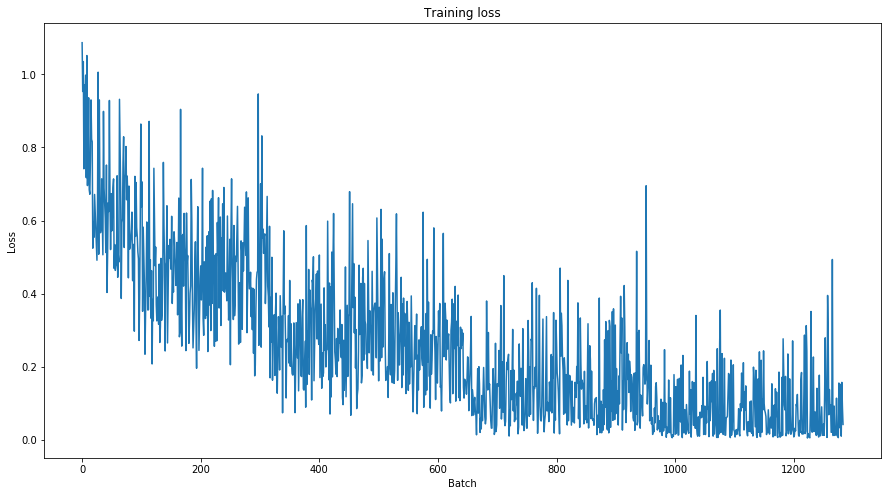

In [76]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()